In [1]:
import arviz as az
import pickle

import corner
import cornerhex

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import fsolve
import time
import copy
# from tqdm import tqdm, trange

import pandas as pd

import json as js
from tqdm import tqdm
    
from snuddd.jinterp import interp1d

In [2]:
import tqdm.utils
def ssl(x):
    return 150, 200
tqdm.utils._screen_shape_linux = ssl
from tqdm import tqdm, trange

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #select GPU, -1 means use CPU

from jax import config
config.update("jax_enable_x64", True)

In [4]:
import jax
import jax.numpy as jnp

from snuddd import config
from snuddd.targets import Nucleus, electron_xe, Electron
from snuddd.models import GeneralNSI

import numpyro
from numpyro import optim
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro import infer
from numpyro.infer import MCMC, NUTS, autoguide, reparam
from numpyro.handlers import trace, seed
from numpyro.infer.util import log_density

CUDA backend failed to initialize: Unable to load CUDA. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
import numpyro
from numpyro import distributions as dist, infer
from numpyro import handlers


DIMENSIONS = 3
N_DATA = 2

data = jax.random.normal(jax.random.PRNGKey(0), shape=(N_DATA, DIMENSIONS))

def model(data, n_samples=N_DATA, dim=DIMENSIONS):
    mu = numpyro.sample("mu", dist.MultivariateNormal(0, 10*jnp.eye(DIMENSIONS)))
    log_cov = numpyro.sample("log_cov", dist.MultivariateNormal(0, 10*jnp.eye(DIMENSIONS)))
    with numpyro.plate("data", n_samples) as ind:
        numpyro.sample("obs", dist.MultivariateNormal(mu, jnp.diag(jnp.exp(log_cov))), obs=data)
    

In [12]:
sampler = infer.MCMC(
    infer.NUTS(model, step_size=1e-3, adapt_step_size=True, max_tree_depth=11, target_accept_prob=0.8),
    num_warmup=3000,
    num_samples=5000,
    num_chains=4,
    progress_bar=True,
    chain_method='sequential'
)

In [13]:

%time sampler.run(jax.random.PRNGKey(0), data)

sample: 100%|████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 3111.61it/s, 15 steps of size 2.15e-01. acc. prob=0.85]


CPU times: user 14.1 s, sys: 214 ms, total: 14.3 s
Wall time: 14.2 s


In [15]:
sampler.print_summary()
samples_1 = sampler.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
log_cov[0]     -0.74      1.56     -0.93     -3.17      1.77   3874.71      1.00
log_cov[1]     -0.51      1.50     -0.71     -2.93      1.81   4044.32      1.00
log_cov[2]     -1.84      1.80     -2.07     -4.70      0.96   3627.07      1.00
     mu[0]      0.81      0.82      0.87     -0.26      2.04   3137.66      1.00
     mu[1]     -0.68      0.82     -0.73     -1.90      0.56   3376.44      1.00
     mu[2]      0.56      0.58      0.56     -0.26      1.32   2836.41      1.00

Number of divergences: 90


In [16]:
arviz_obj_chain = az.from_numpyro(sampler)

In [17]:
az.summary(arviz_obj_chain)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_cov[0],-0.740,1.559,-3.373,2.241,0.025,0.018,4350.0,4683.0,1.0
log_cov[1],-0.512,1.499,-3.006,2.377,0.024,0.017,4444.0,5283.0,1.0
log_cov[2],-1.839,1.796,-4.919,1.500,0.030,0.021,3892.0,4807.0,1.0
mu[0],0.810,0.815,-0.747,2.293,0.015,0.011,5043.0,3333.0,1.0
mu[1],-0.684,0.817,-2.197,1.000,0.014,0.011,4785.0,3397.0,1.0
mu[2],0.560,0.584,-0.557,1.645,0.011,0.008,4361.0,3385.0,1.0


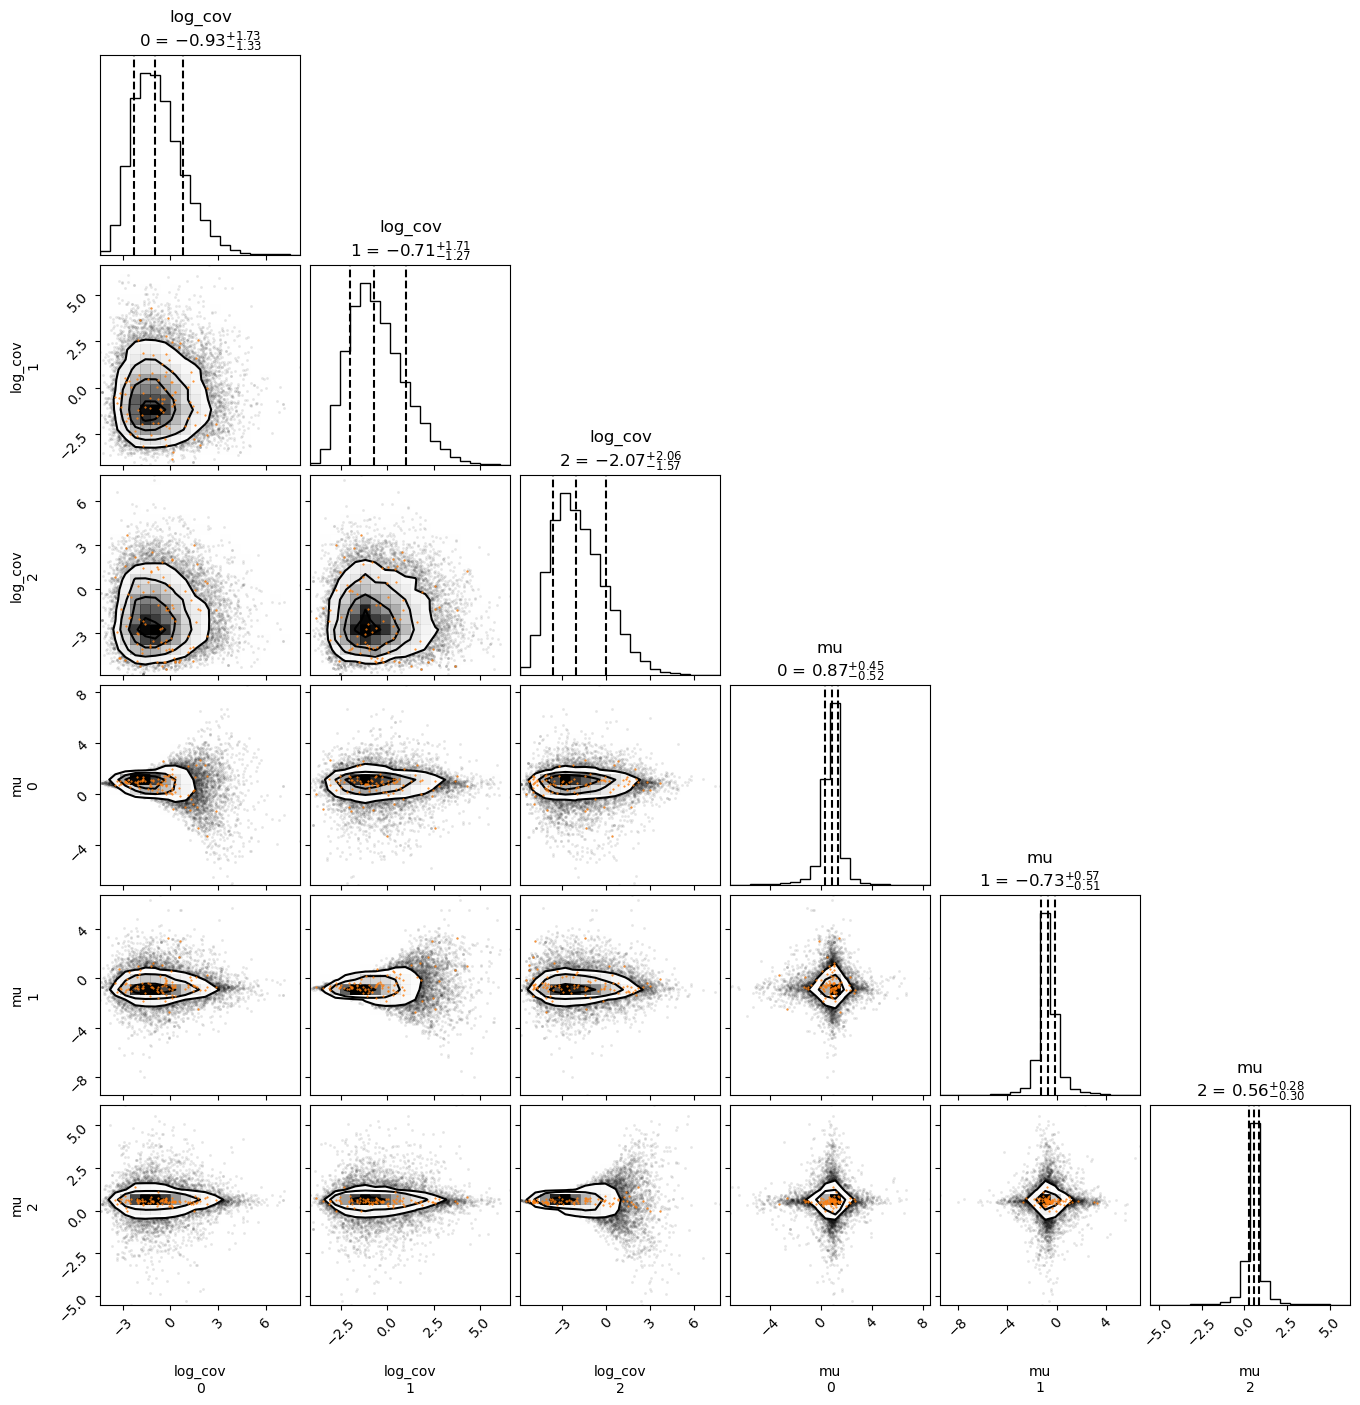

In [18]:
fig = corner.corner(arviz_obj_chain, quantiles=[0.16, 0.5, 0.84], show_titles=True, divergences=True)

# Show the plot
fig.show()


In [19]:
names = []
for site in trace(seed(model, jax.random.PRNGKey(0))).get_trace(data).values():
    names.append(site['name'])

In [22]:
pln_samples = {}
for var in names[:-2]:
    for i in range(DIMENSIONS):
        pln_samples[var+f'[{i}]'] = arviz_obj_chain.posterior[var].values[...,i]

In [23]:
sample_dict = sampler.get_samples()
last_sample = {}
for k in sample_dict:
    last_sample[k] = sample_dict[k][-1]

In [26]:
import ultranest
import ultranest.calibrator
import ultranest.stepsampler

In [30]:
@jax.jit
def prior_transform(cube, scale=2):
    return jax.scipy.special.logit(cube)*scale

In [31]:
@jax.jit
def inverse_prior(x, scale=2):
    return jax.nn.sigmoid(x/scale)

In [33]:
ns_names = [names[0] + f'[{i}]' for i in range((DIMENSIONS))] + [names[1] + f'[{i}]' for i in range((DIMENSIONS))]

In [36]:
prior_jac = jax.jit(jax.jacfwd(prior_transform))

@jax.jit
def log_density_func(in_arr, names=names):
    samples = {
        names[0]: in_arr[0:DIMENSIONS],
        names[1]: in_arr[DIMENSIONS:]
    }
    llh = log_density(model, (data,), {}, samples)[0]
    return jnp.nan_to_num(llh + jnp.linalg.slogdet(prior_jac(inverse_prior(in_arr)))[1], nan=-jnp.finfo(jnp.result_type(float)).max)

In [41]:
import logging
import sys
logger = logging.getLogger("ultranest")
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('[ultranest] [%(levelname)s] %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [46]:

sampler = ultranest.ReactiveNestedSampler(ns_names, log_density_func, prior_transform,
    log_dir="ultranest_gauss", resume='overwrite')

In [48]:
starttime = time.time()
result = sampler.run(min_num_live_points=1600)
endtime = time.time()

[ultranest] [INFO] Sampling 1600 live points from prior ...


INFO:ultranest:Sampling 1600 live points from prior ...


[ultranest] [INFO] Explored until L=0.3  75..-0.5273]*| it/evals=24555/251985 eff=9.8069% N=1600     0  


INFO:ultranest:Explored until L=0.3  


[ultranest] [INFO] Likelihood function evaluations: 252051


INFO:ultranest:Likelihood function evaluations: 252051


[ultranest] [INFO] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] [INFO] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done


[ultranest] [INFO]   logZ = -11.05 +- 0.04553


INFO:ultranest:  logZ = -11.05 +- 0.04553


[ultranest] [INFO] Effective samples strategy satisfied (ESS = 14309.4, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 14309.4, need >400)


[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.05, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.05, need <0.5)


[ultranest] [INFO]   logZ error budget: single: 0.06 bs:0.05 tail:0.01 total:0.05 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.06 bs:0.05 tail:0.01 total:0.05 required:<0.50


[ultranest] [INFO] done iterating.


INFO:ultranest:done iterating.


In [50]:
result['runtime'] = endtime - starttime

In [54]:
## with open('ns_runtimes.pickle', 'rb') as f:
#     current_results = pickle.load(f)
current_results = []

In [62]:
current_results.append(result)
with open('ns_runtimes_gauss.pickle', 'wb') as f:
    pickle.dump(current_results, f)

In [64]:
dict_for_plot = {}
for i, n in enumerate(ns_names):
    dict_for_plot[n] = current_results[0]['samples'][:,i]


# with open('ns_corner_gauss_samples.pickle', 'wb') as f:
#     pickle.dump(dict_for_plot, f)

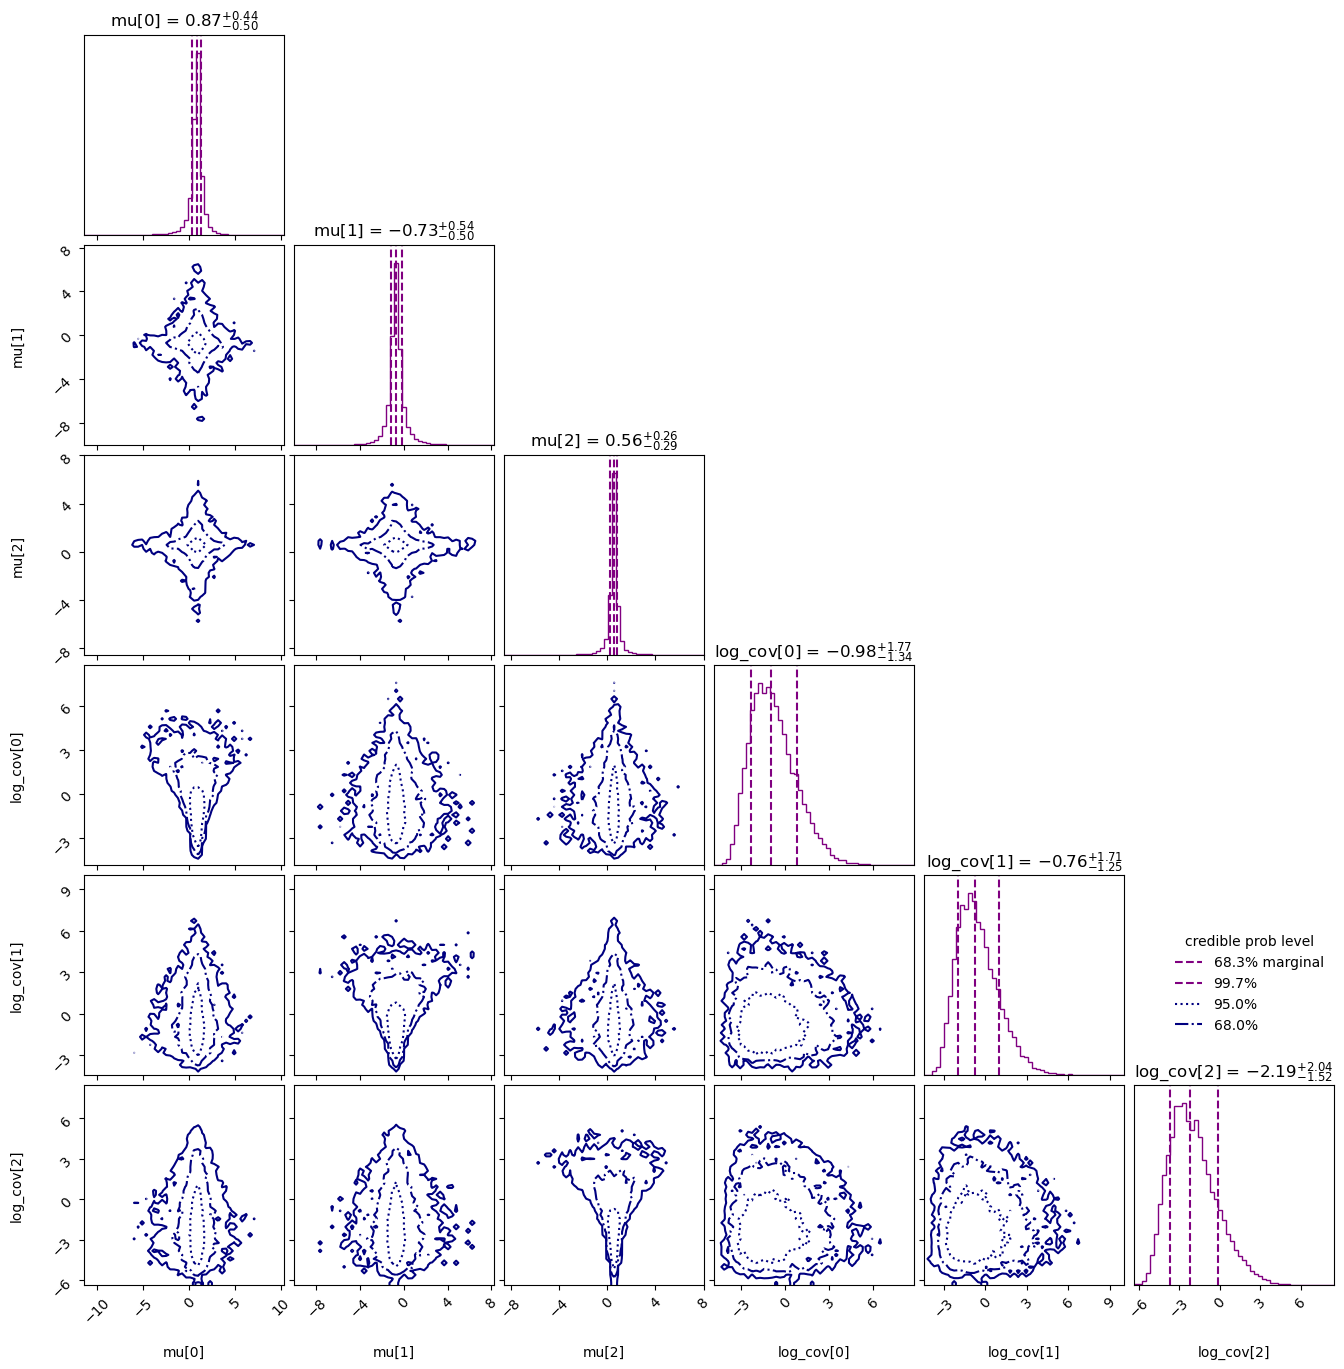

In [66]:
from ultranest.plot import cornerplot
cornerplot(current_results[0], levels=[0.68, 0.95, 0.997], bins=50)
plt.show()

In [69]:
import optax

In [70]:
guide = autoguide.AutoBNAFNormal(
    model,
    hidden_factors=[4, 4],
    num_flows=2
    )

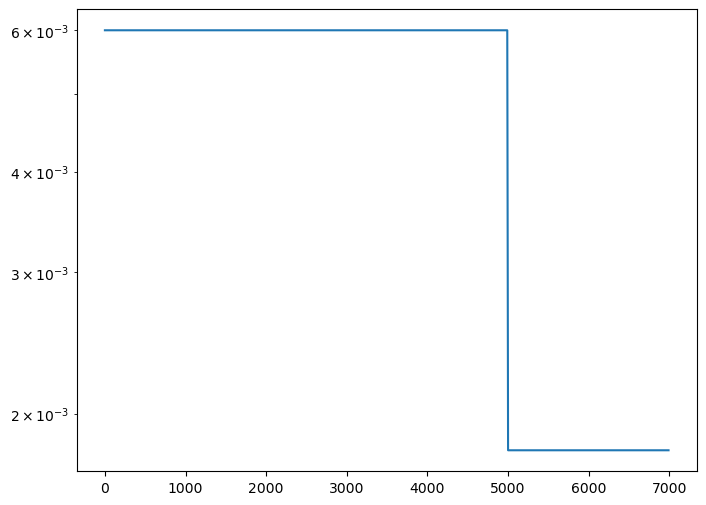

In [75]:
N_1 = 5000
N_2 = 2000
epochs = N_1 + N_2
high_lr = 0.6e-2
lr_multiplier = 0.3
schedule = optax.join_schedules([optax.constant_schedule(high_lr), optax.constant_schedule(high_lr*lr_multiplier)], [N_1])
x = np.arange(0, epochs, 10)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(
    x,
    [schedule(i) for i in x],
)
ax.set(yscale='log')
plt.show()

In [76]:
svi = infer.SVI(model, guide, optax.adamw(schedule), infer.Trace_ELBO(num_particles=30))

In [77]:
svi_result = svi.run(jax.random.PRNGKey(0), epochs, data)

100%|████████████████████████████████████████████████████████| 7000/7000 [00:10<00:00, 685.54it/s, init loss: 25.5138, avg. loss [6651-7000]: 11.2071]


In [78]:
np.mean(svi_result.losses[-100:])

Array(11.21475567, dtype=float64)

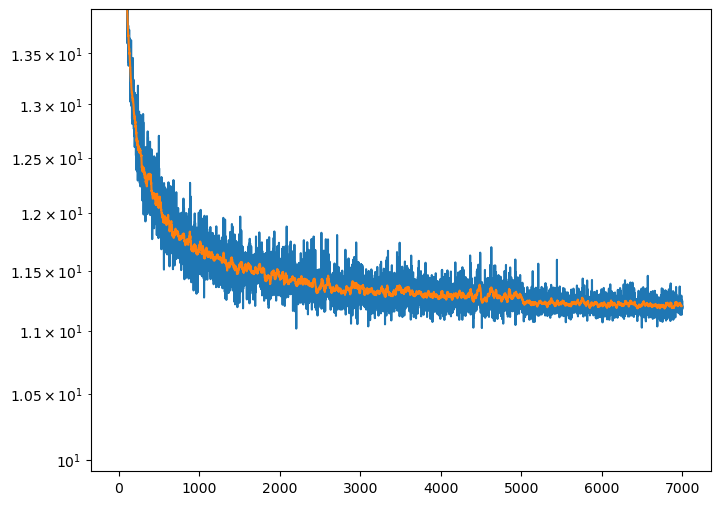

In [79]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(svi_result.losses)
ax.plot(np.arange(10, len(svi_result.losses)-10), np.convolve(svi_result.losses, [1/21]*21, mode='valid'))
ax.set(yscale='log', ylim=[np.min(svi_result.losses)*0.9, svi_result.losses[100]])
plt.show()

In [80]:
import pickle

In [ ]:
# with open("params_gauss.pickle", "wb") as f:
#     pickle.dump(svi_result.params, f)

In [82]:
with open("params_gauss.pickle", "rb") as f:
    loaded_dict = pickle.load(f)

In [83]:
neutra = infer.reparam.NeuTraReparam(guide, loaded_dict)
neutra_model = neutra.reparam(model)

In [84]:
neutra_names = []
for site in trace(seed(neutra_model, jax.random.PRNGKey(0))).get_trace(data).values():
    neutra_names.append(site['name'])

In [87]:
@jax.jit
def prior_transform_nn(cube, scale=2):
    return jax.scipy.special.logit(cube)*scale

In [88]:
@jax.jit
def inverse_prior_nn(x, scale=2):
    return jax.nn.sigmoid(x/scale)

In [89]:
prior_jac_nn = jax.jit(jax.jacfwd(prior_transform_nn))

In [90]:
@jax.jit
def log_density_func_nn(x, names=names):
    # x = jnp.concatenate([eps, phi, sineta])
    samples = {
        'auto_shared_latent': x
    }
    llh = log_density(neutra_model, (data,), {}, samples)[0]
    return jnp.nan_to_num(llh + jnp.linalg.slogdet(prior_jac_nn(inverse_prior_nn(x)))[1], nan=-jnp.finfo(jnp.result_type(float)).max)

In [93]:
nn_names_nn = [f'latent_{i}' for i in range((2*DIMENSIONS))]

In [94]:

sampler_nn = ultranest.ReactiveNestedSampler(nn_names_nn, log_density_func_nn, prior_transform_nn,
    log_dir="ultranest_gauss_w_neutra", resume='overwrite')

In [95]:
starttime = time.time()
result_nn = sampler_nn.run(min_num_live_points=2400)
endtime = time.time()

[ultranest] [INFO] Sampling 2400 live points from prior ...


INFO:ultranest:Sampling 2400 live points from prior ...


[ultranest] [INFO] Explored until L=-4  7392..-4.7391]*| it/evals=26747/170249 eff=15.9352% N=2400 


INFO:ultranest:Explored until L=-4  


[ultranest] [INFO] Likelihood function evaluations: 170257


INFO:ultranest:Likelihood function evaluations: 170257


[ultranest] [INFO] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] [INFO] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done


[ultranest] [INFO]   logZ = -11.18 +- 0.03112


INFO:ultranest:  logZ = -11.18 +- 0.03112


[ultranest] [INFO] Effective samples strategy satisfied (ESS = 14020.4, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 14020.4, need >400)


[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.03, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.03, need <0.5)


[ultranest] [INFO]   logZ error budget: single: 0.04 bs:0.03 tail:0.01 total:0.03 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.04 bs:0.03 tail:0.01 total:0.03 required:<0.50


[ultranest] [INFO] done iterating.


INFO:ultranest:done iterating.


In [96]:
result_nn['runtime'] = endtime - starttime

In [101]:
# with open('ns_neutra_runtimes_funnel.pickle', 'rb') as f:
#     current_results_neutra = pickle.load(f)
current_results_neutra = []

In [102]:
current_results_neutra.append(result_nn)
with open('ns_neutra_runtimes_gauss.pickle', 'wb') as f:
    pickle.dump(current_results_neutra, f)

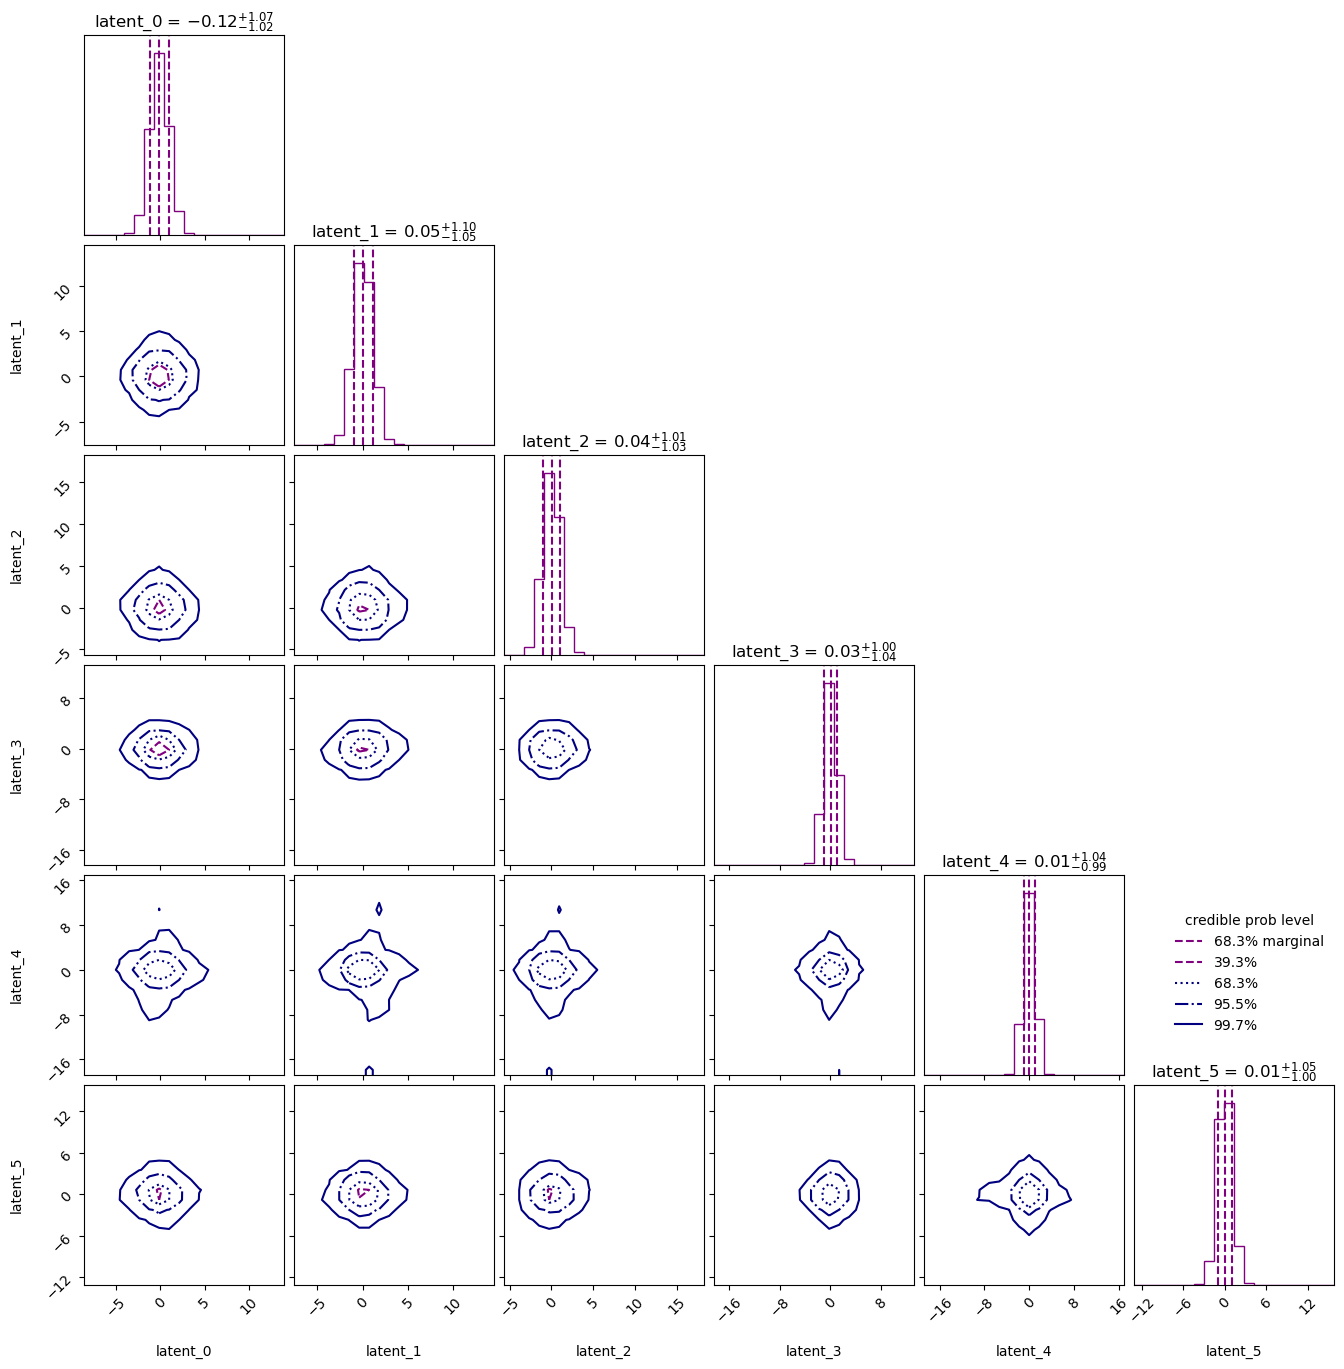

In [103]:
cornerplot(current_results_neutra[0])
plt.show()

In [110]:
samples_nn_transformed = neutra.transform_sample(current_results_neutra[0]['samples'])

In [114]:
dict_for_plot_nn = {}
for i, n in enumerate(ns_names):
    if i<DIMENSIONS:
        dict_for_plot_nn[n] = samples_nn_transformed['mu'][:,i]
    else:
        dict_for_plot_nn[n] = samples_nn_transformed['log_cov'][:,i-DIMENSIONS]


with open('ns_neutra_corner_gauss_samples.pickle', 'wb') as f:
    pickle.dump(dict_for_plot_nn, f)

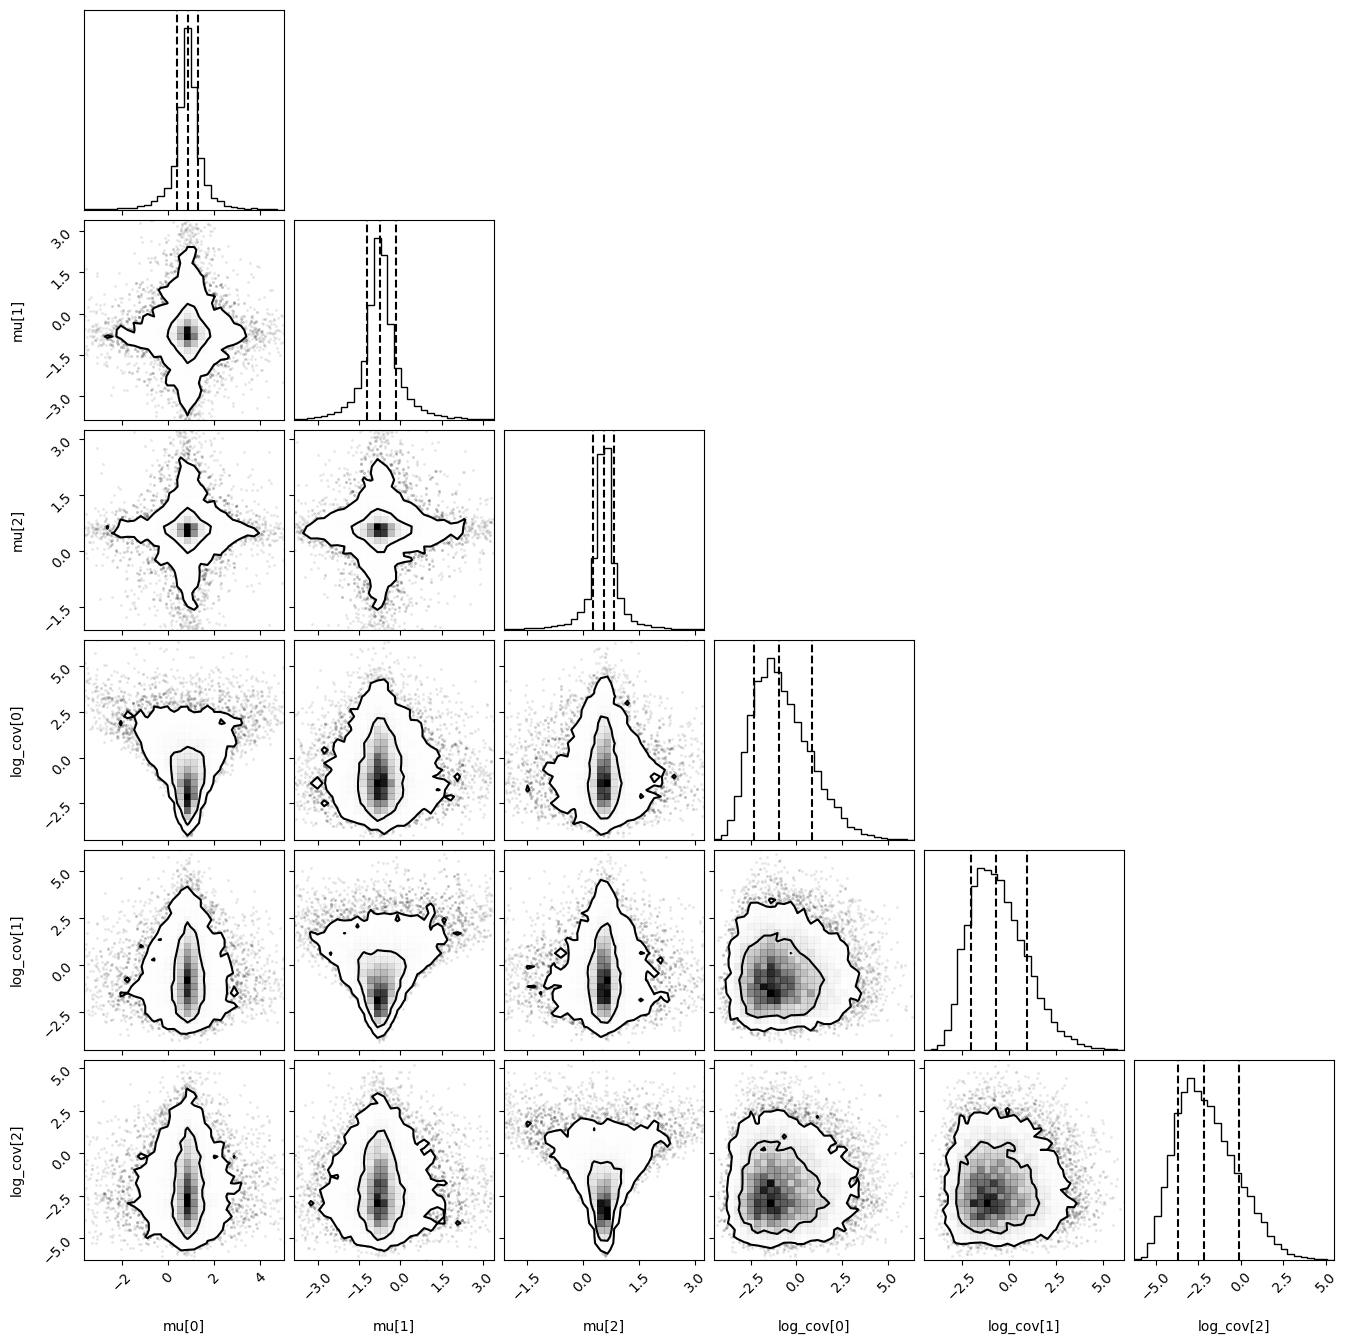

In [117]:
fig = corner.corner(dict_for_plot_nn, quantiles=[0.16, 0.5, 0.84], bins=30, divergences=True, levels=[0.68, 0.95])

fig.show()

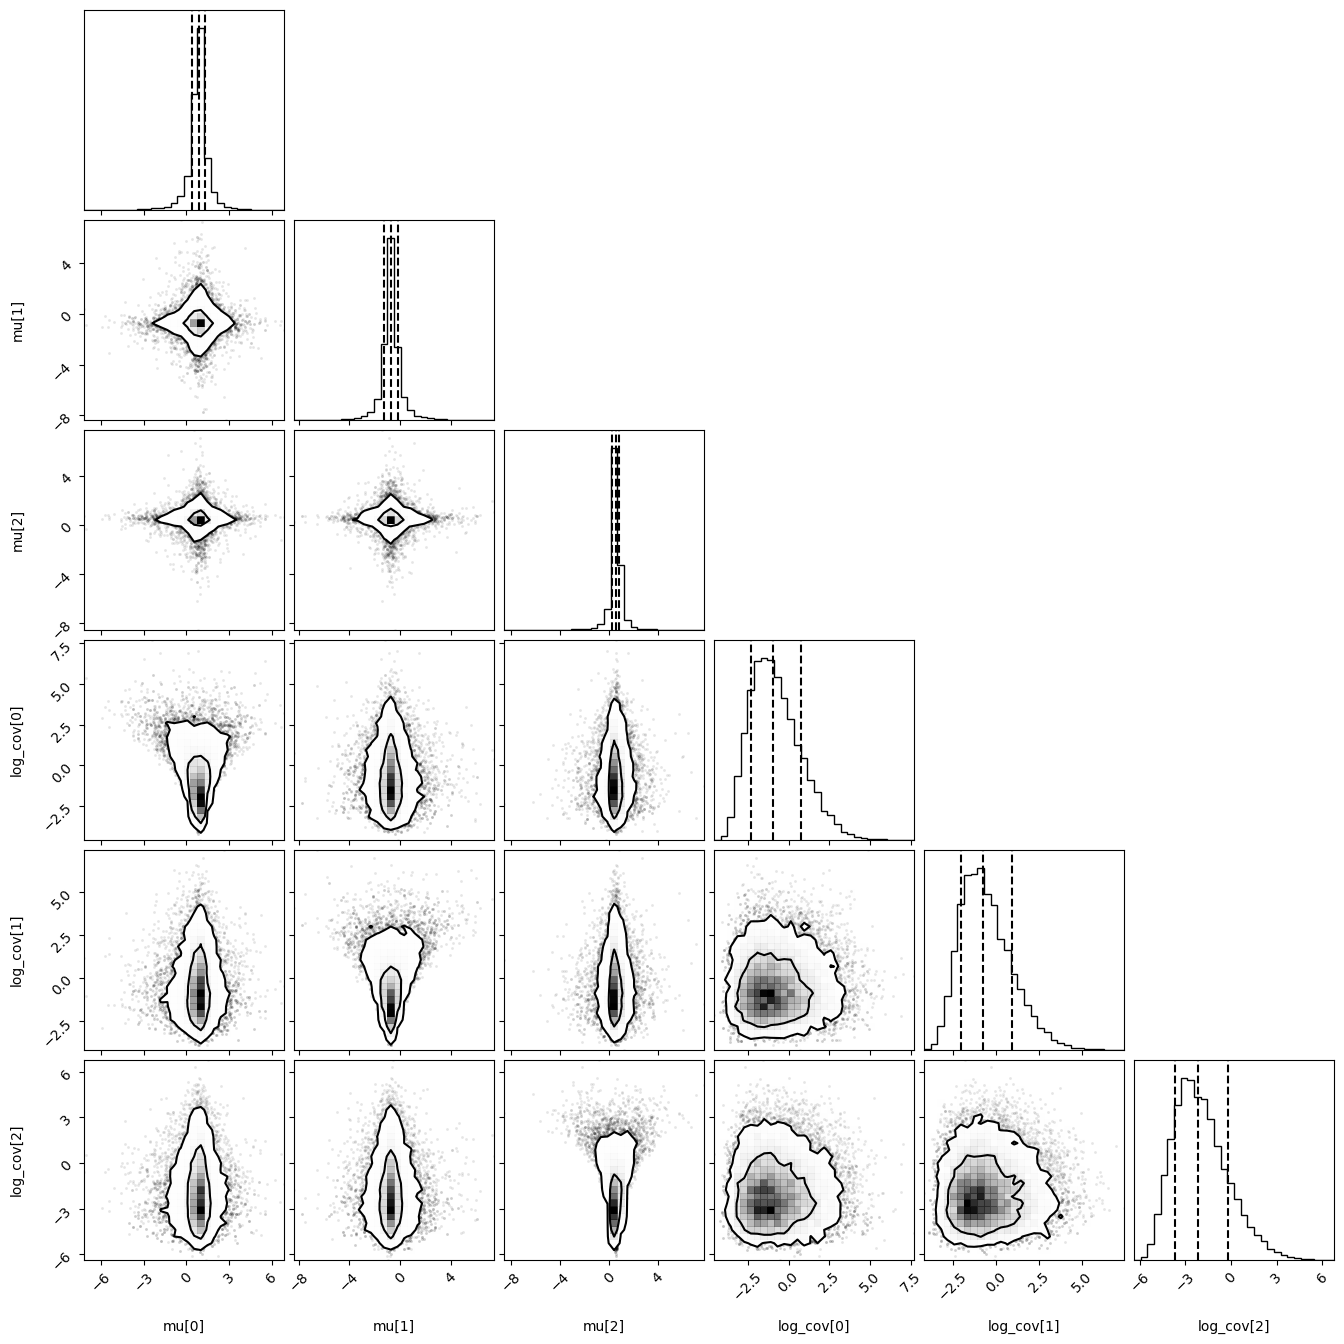

In [118]:
fig = corner.corner(dict_for_plot, quantiles=[0.16, 0.5, 0.84], bins=30, divergences=True, levels=[0.68, 0.95])

fig.show()

In [119]:
kernel = infer.NUTS(neutra_model, target_accept_prob=0.8)

sampler = infer.MCMC(kernel,
    num_warmup=3000,
    num_samples=5000,
    num_chains=4,
    progress_bar=True,
    chain_method='sequential'
)

In [120]:

%time sampler.run(jax.random.PRNGKey(0), data)
arviz_obj = az.from_numpyro(sampler)

sample: 100%|█████████████████████████████████████████████████████████| 8000/8000 [00:03<00:00, 2365.38it/s, 7 steps of size 5.35e-01. acc. prob=0.89]


CPU times: user 19.8 s, sys: 253 ms, total: 20 s
Wall time: 19.7 s


In [122]:
sampler.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
auto_shared_latent[0]     -0.08      1.07     -0.09     -1.76      1.66  21576.76      1.00
auto_shared_latent[1]      0.06      1.09      0.05     -1.66      1.82  19374.48      1.00
auto_shared_latent[2]      0.03      1.02      0.04     -1.65      1.66  26004.03      1.00
auto_shared_latent[3]      0.02      1.04      0.03     -1.62      1.70  23755.41      1.00
auto_shared_latent[4]      0.02      1.42      0.02     -1.58      1.75   4316.41      1.00
auto_shared_latent[5]      0.04      1.04      0.01     -1.60      1.78  21618.07      1.00

Number of divergences: 0


In [124]:
az.summary(arviz_obj, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
auto_shared_latent[0],-0.0755,1.0660,-2.0707,1.8808,0.0072,0.0098,23870.5053,13005.1713,1.0003
auto_shared_latent[1],0.0569,1.0916,-2.0054,1.9875,0.0078,0.0097,21285.6155,12503.3697,1.0000
auto_shared_latent[2],0.0292,1.0166,-1.8777,1.9451,0.0063,0.0080,26670.3285,14690.0013,1.0009
auto_shared_latent[3],0.0205,1.0388,-1.8952,1.8987,0.0067,0.0105,24731.2142,14084.0028,1.0007
auto_shared_latent[4],0.0156,1.4186,-1.8977,1.9080,0.0216,0.0301,13511.3974,8164.1434,1.0003
auto_shared_latent[5],0.0370,1.0358,-1.8629,1.9796,0.0071,0.0090,22713.9984,13710.0178,1.0008
log_cov[0],-0.7794,1.5319,-3.4673,2.0474,0.0128,0.0091,15159.6091,13737.8035,1.0003
log_cov[1],-0.5441,1.4743,-3.1146,2.2373,0.0127,0.0109,15103.1824,10222.9549,1.0003
log_cov[2],-1.9262,1.7425,-4.8816,1.4020,0.0147,0.0104,14784.6783,13603.9546,1.0002
mu[0],0.8487,0.7400,-0.6795,2.3476,0.0052,0.0054,22963.1927,13864.6279,1.0006


In [125]:
print(f"{int(np.sum(arviz_obj.sample_stats['diverging']))} divergences")

0 divergences


In [127]:
labels = [k for k in arviz_obj.posterior.keys()]

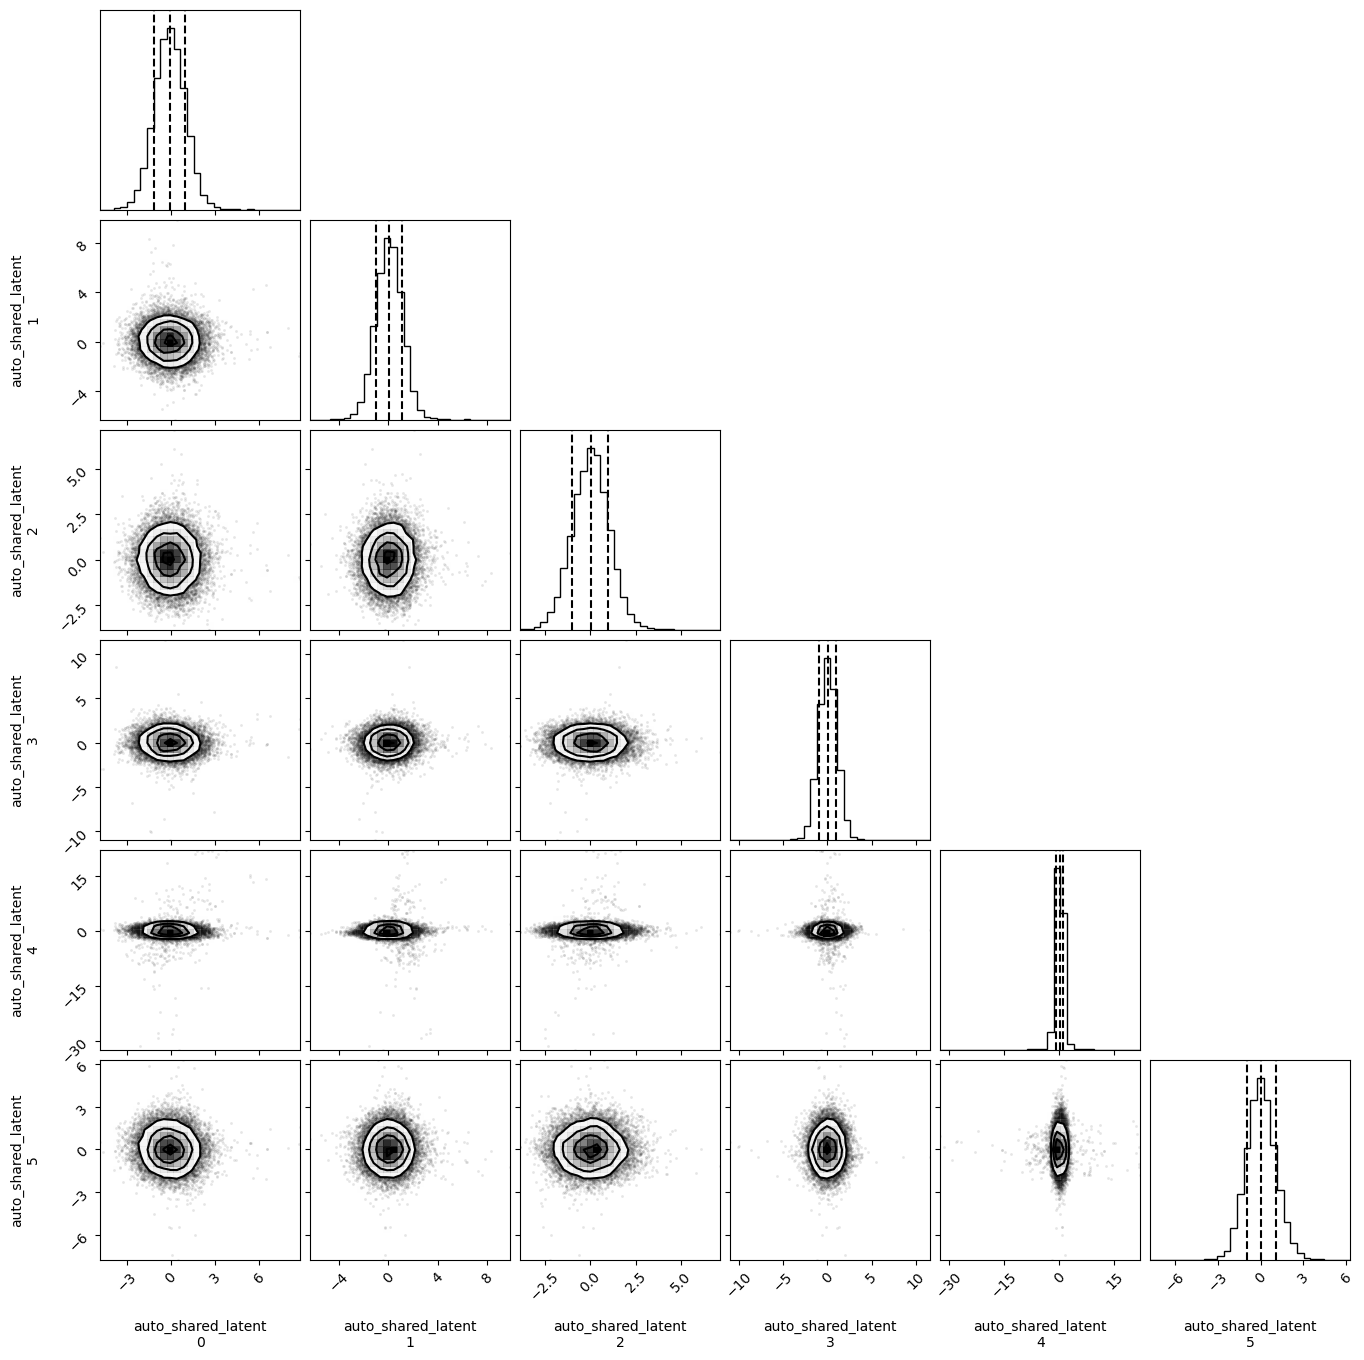

In [130]:
fig = corner.corner(arviz_obj, quantiles=[0.16, 0.5, 0.84], var_names=['auto_shared_latent'], bins=30, divergences=True)

# Show the plot
fig.show()

/home/juehang/.conda/envs/numpyro_gpu/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['phi_unwrapped'] have not been found and will be ignored
  warnings.warn(


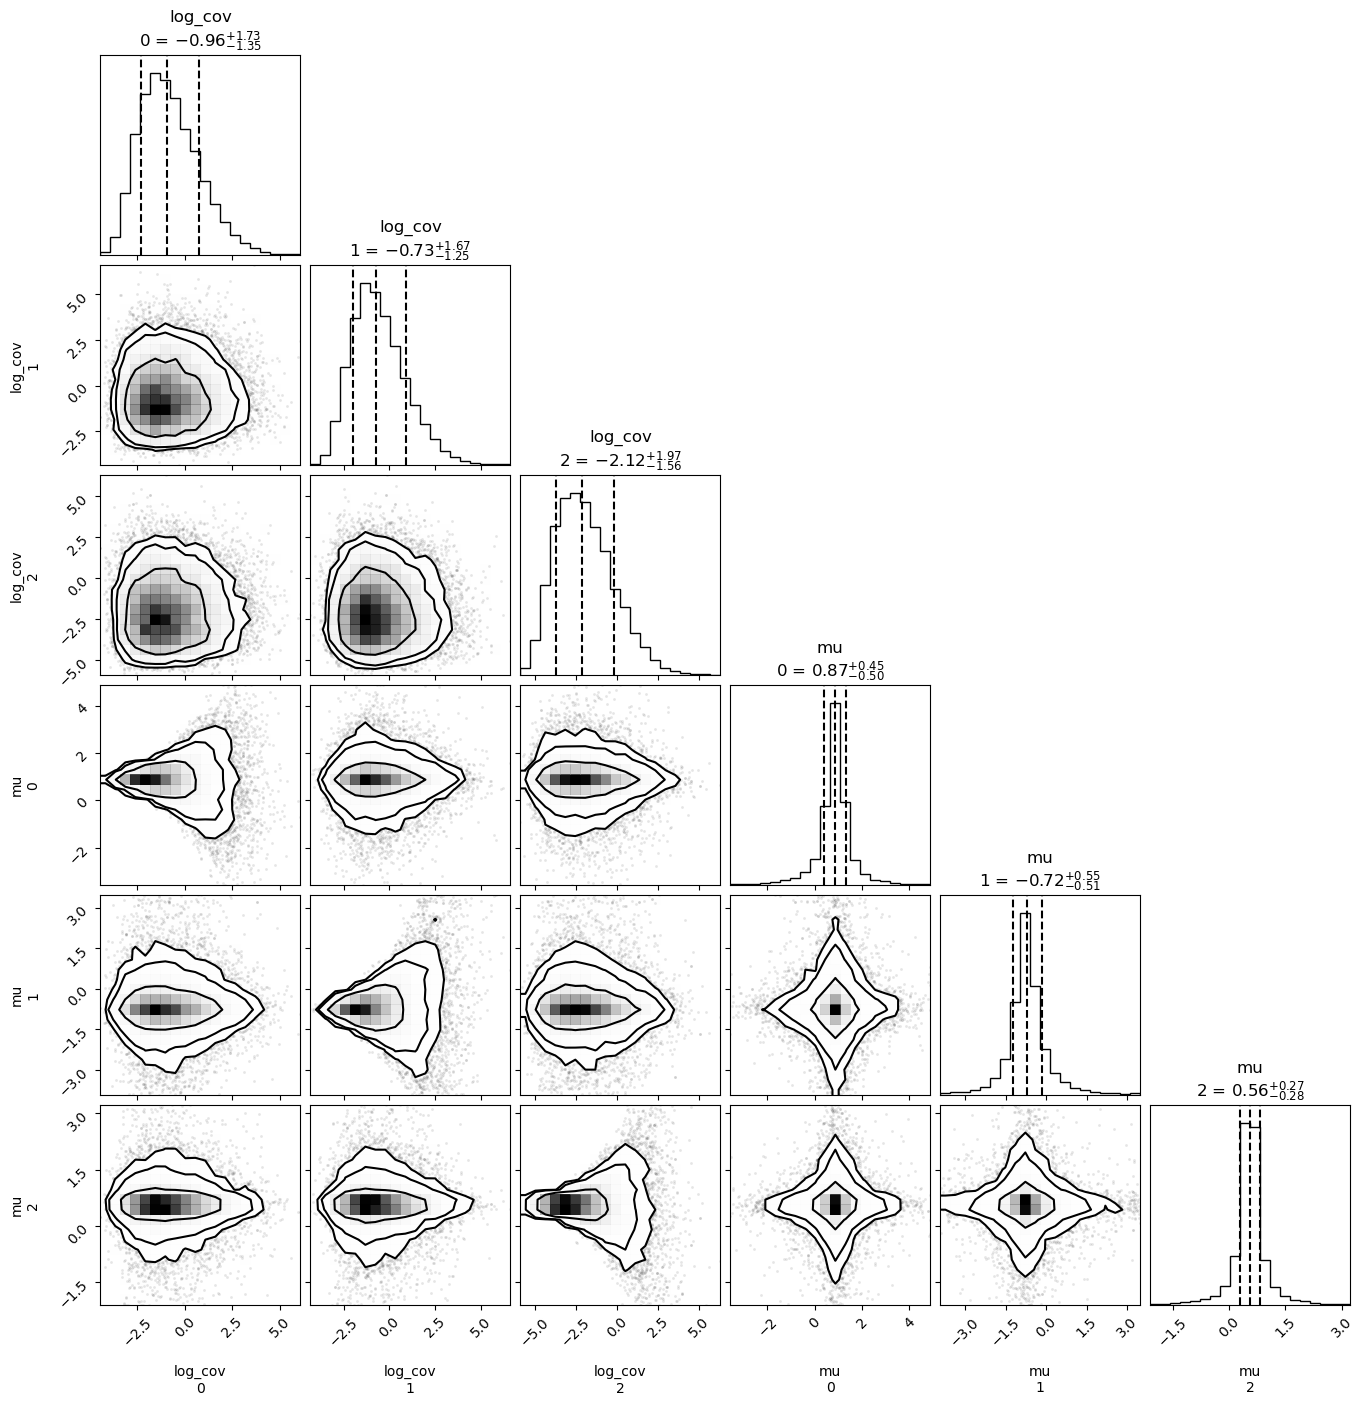

In [131]:
fig = corner.corner(arviz_obj, quantiles=[0.16, 0.5, 0.84], show_titles=True, var_names=['~auto_shared_latent', '~phi_unwrapped'], bins=20, divergences=True, levels=[0.68, 0.9, 0.95])

# Show the plot
fig.show()

In [132]:
pln_samples = {}
for var in names[:-2]:
    for i in range(DIMENSIONS):
        pln_samples[var+f'[{i}]'] = arviz_obj.posterior[var].values[...,i]

with open('neutra_gausstoy.pkl', 'wb') as handle:
    pickle.dump(pln_samples, handle)

In [134]:
bench_sampler = infer.MCMC(
    infer.NUTS(model, target_accept_prob=0.8),
    num_warmup=3000,
    num_samples=5000,
    num_chains=1,
    progress_bar=True,
    chain_method='sequential'
)

bench_nn_sampler = infer.MCMC(
    infer.NUTS(neutra_model, target_accept_prob=0.8),
    num_warmup=3000,
    num_samples=5000,
    num_chains=1,
    progress_bar=True,
    chain_method='sequential'
)


In [135]:
N_chains = 4

nuts_measurements = {
    'ESS': np.zeros(N_chains),
    'calls': np.zeros(N_chains),
    'divergences': np.zeros(N_chains),
    'runtime': np.zeros(N_chains),
    'logZ': np.zeros(N_chains),
    'logZerr': np.zeros(N_chains),
}

nn_nuts_measurements = copy.deepcopy(nuts_measurements)

ns_measurements = copy.deepcopy(nuts_measurements)

nn_ns_measurements = copy.deepcopy(nuts_measurements)

key = jax.random.PRNGKey(42)

for i in range(N_chains):
    key, thiskey = jax.random.split(key)
    starttime = time.time()
    bench_sampler.run(thiskey, data, extra_fields=('num_steps',))
    endtime = time.time()
    bench_az_obj = az.from_numpyro(bench_sampler)
    nuts_measurements['ESS'][i] = float(np.min(az.ess(bench_az_obj).to_array()))
    nuts_measurements['calls'][i] = float(bench_az_obj['sample_stats']['n_steps'].sum())
    nuts_measurements['divergences'][i] = int(bench_az_obj['sample_stats']['diverging'].sum())
    nuts_measurements['runtime'][i] = endtime - starttime
    
    starttime = time.time()
    bench_nn_sampler.run(thiskey, data, extra_fields=('num_steps',))
    endtime = time.time()
    bench_az_obj = az.from_numpyro(bench_nn_sampler)
    nn_nuts_measurements['ESS'][i] = float(np.min(az.ess(bench_az_obj)[['log_cov', 'mu']].to_array()))
    nn_nuts_measurements['calls'][i] = float(bench_az_obj['sample_stats']['n_steps'].sum())
    nn_nuts_measurements['divergences'][i] = int(bench_az_obj['sample_stats']['diverging'].sum())
    nn_nuts_measurements['runtime'][i] = endtime - starttime
    
    bench_ns_sampler = ultranest.ReactiveNestedSampler(ns_names, log_density_func, prior_transform,
    log_dir="ultranest_gauss_bench", resume='overwrite')
    starttime = time.time()
    bench_result = bench_ns_sampler.run(min_num_live_points=1600)
    endtime = time.time()
    ns_measurements['ESS'][i] = bench_result['ess']
    ns_measurements['calls'][i] = bench_result['ncall']
    ns_measurements['runtime'][i] = endtime - starttime
    ns_measurements['logZ'][i] = bench_result['logz']
    ns_measurements['logZerr'][i] = bench_result['logzerr']
    
    
    bench_ns_nn_sampler = ultranest.ReactiveNestedSampler(nn_names_nn, log_density_func_nn, prior_transform_nn,
    log_dir="ultranest_gauss_w_neutra_bench", resume='overwrite')
    starttime = time.time()
    bench_result_nn = bench_ns_nn_sampler.run(min_num_live_points=2400)
    endtime = time.time()
    nn_ns_measurements['ESS'][i] = bench_result_nn['ess']
    nn_ns_measurements['calls'][i] = bench_result_nn['ncall']
    nn_ns_measurements['runtime'][i] = endtime - starttime
    nn_ns_measurements['logZ'][i] = bench_result_nn['logz']
    nn_ns_measurements['logZerr'][i] = bench_result_nn['logzerr']

sample: 100%|█████████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1116.89it/s, 7 steps of size 6.23e-01. acc. prob=0.88]


[ultranest] [INFO] Sampling 1600 live points from prior ...


INFO:ultranest:Sampling 1600 live points from prior ...


[ultranest] [INFO] Explored until L=0.3  05..-0.5504]*| it/evals=24712/307659 eff=8.0743% N=1600     0  


INFO:ultranest:Explored until L=0.3  


[ultranest] [INFO] Likelihood function evaluations: 307704


INFO:ultranest:Likelihood function evaluations: 307704


[ultranest] [INFO] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] [INFO] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done


[ultranest] [INFO]   logZ = -11.18 +- 0.04357


INFO:ultranest:  logZ = -11.18 +- 0.04357


[ultranest] [INFO] Effective samples strategy satisfied (ESS = 14593.4, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 14593.4, need >400)


[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)


[ultranest] [INFO]   logZ error budget: single: 0.06 bs:0.04 tail:0.01 total:0.04 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.06 bs:0.04 tail:0.01 total:0.04 required:<0.50


[ultranest] [INFO] done iterating.


INFO:ultranest:done iterating.


[ultranest] [INFO] Sampling 2400 live points from prior ...


INFO:ultranest:Sampling 2400 live points from prior ...


[ultranest] [INFO] Explored until L=-4  7431..-4.7431]*| it/evals=26757/140982 eff=19.3077% N=2400  


INFO:ultranest:Explored until L=-4  


[ultranest] [INFO] Likelihood function evaluations: 141038


INFO:ultranest:Likelihood function evaluations: 141038


[ultranest] [INFO] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] [INFO] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done


[ultranest] [INFO]   logZ = -11.19 +- 0.03137


INFO:ultranest:  logZ = -11.19 +- 0.03137


[ultranest] [INFO] Effective samples strategy satisfied (ESS = 13965.9, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 13965.9, need >400)


[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.02 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.02 nat, need <0.50 nat)


[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.03, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.03, need <0.5)


[ultranest] [INFO]   logZ error budget: single: 0.04 bs:0.03 tail:0.01 total:0.03 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.04 bs:0.03 tail:0.01 total:0.03 required:<0.50


[ultranest] [INFO] done iterating.


INFO:ultranest:done iterating.
sample: 100%|█████████████████████████████████████████████████████████| 8000/8000 [00:03<00:00, 2188.07it/s, 7 steps of size 5.61e-01. acc. prob=0.85]


[ultranest] [INFO] Sampling 1600 live points from prior ...


INFO:ultranest:Sampling 1600 live points from prior ...


[ultranest] [INFO] Explored until L=0.3  34..-0.5932]*| it/evals=24480/299984 eff=8.2042% N=1600   0 0  


INFO:ultranest:Explored until L=0.3  


[ultranest] [INFO] Likelihood function evaluations: 300092


INFO:ultranest:Likelihood function evaluations: 300092


[ultranest] [INFO] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] [INFO] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done


[ultranest] [INFO]   logZ = -11.05 +- 0.04203


INFO:ultranest:  logZ = -11.05 +- 0.04203


[ultranest] [INFO] Effective samples strategy satisfied (ESS = 14393.8, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 14393.8, need >400)


[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)


[ultranest] [INFO]   logZ error budget: single: 0.06 bs:0.04 tail:0.01 total:0.04 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.06 bs:0.04 tail:0.01 total:0.04 required:<0.50


[ultranest] [INFO] done iterating.


INFO:ultranest:done iterating.


[ultranest] [INFO] Sampling 2400 live points from prior ...


INFO:ultranest:Sampling 2400 live points from prior ...


[ultranest] [INFO] Explored until L=-4  7249..-4.7248]*| it/evals=26640/98064 eff=27.8475% N=2400  


INFO:ultranest:Explored until L=-4  


[ultranest] [INFO] Likelihood function evaluations: 98133


INFO:ultranest:Likelihood function evaluations: 98133


[ultranest] [INFO] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] [INFO] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done


[ultranest] [INFO]   logZ = -11.14 +- 0.02974


INFO:ultranest:  logZ = -11.14 +- 0.02974


[ultranest] [INFO] Effective samples strategy satisfied (ESS = 13690.5, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 13690.5, need >400)


[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.02 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.02 nat, need <0.50 nat)


[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.03, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.03, need <0.5)


[ultranest] [INFO]   logZ error budget: single: 0.04 bs:0.03 tail:0.01 total:0.03 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.04 bs:0.03 tail:0.01 total:0.03 required:<0.50


[ultranest] [INFO] done iterating.


INFO:ultranest:done iterating.
sample: 100%|█████████████████████████████████████████████████████████| 8000/8000 [00:03<00:00, 2286.83it/s, 3 steps of size 7.01e-01. acc. prob=0.84]


[ultranest] [INFO] Sampling 1600 live points from prior ...


INFO:ultranest:Sampling 1600 live points from prior ...


[ultranest] [INFO] Explored until L=0.3  58..-0.5754]*| it/evals=24616/278942 eff=8.8757% N=1600     =1600  0  


INFO:ultranest:Explored until L=0.3  


[ultranest] [INFO] Likelihood function evaluations: 279079


INFO:ultranest:Likelihood function evaluations: 279079


[ultranest] [INFO] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] [INFO] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done


[ultranest] [INFO]   logZ = -11.14 +- 0.05502


INFO:ultranest:  logZ = -11.14 +- 0.05502


[ultranest] [INFO] Effective samples strategy satisfied (ESS = 14341.6, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 14341.6, need >400)


[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)


[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.06, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.06, need <0.5)


[ultranest] [INFO]   logZ error budget: single: 0.06 bs:0.06 tail:0.01 total:0.06 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.06 bs:0.06 tail:0.01 total:0.06 required:<0.50


[ultranest] [INFO] done iterating.


INFO:ultranest:done iterating.


[ultranest] [INFO] Sampling 2400 live points from prior ...


INFO:ultranest:Sampling 2400 live points from prior ...


[ultranest] [INFO] Explored until L=-4  7407..-4.7407]*| it/evals=26640/111005 eff=24.5293% N=2400 


INFO:ultranest:Explored until L=-4  


[ultranest] [INFO] Likelihood function evaluations: 111056


INFO:ultranest:Likelihood function evaluations: 111056


[ultranest] [INFO] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] [INFO] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done


[ultranest] [INFO]   logZ = -11.15 +- 0.02904


INFO:ultranest:  logZ = -11.15 +- 0.02904


[ultranest] [INFO] Effective samples strategy satisfied (ESS = 13868.1, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 13868.1, need >400)


[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.03, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.03, need <0.5)


[ultranest] [INFO]   logZ error budget: single: 0.04 bs:0.03 tail:0.01 total:0.03 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.04 bs:0.03 tail:0.01 total:0.03 required:<0.50


[ultranest] [INFO] done iterating.


INFO:ultranest:done iterating.
sample: 100%|█████████████████████████████████████████████████████████| 8000/8000 [00:03<00:00, 2247.93it/s, 7 steps of size 5.09e-01. acc. prob=0.92]


[ultranest] [INFO] Sampling 1600 live points from prior ...


INFO:ultranest:Sampling 1600 live points from prior ...


[ultranest] [INFO] Explored until L=0.3  94..-0.5691]*| it/evals=24616/315994 eff=7.8297% N=1600      0 


INFO:ultranest:Explored until L=0.3  


[ultranest] [INFO] Likelihood function evaluations: 316025


INFO:ultranest:Likelihood function evaluations: 316025


[ultranest] [INFO] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] [INFO] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done


[ultranest] [INFO]   logZ = -11.1 +- 0.053


INFO:ultranest:  logZ = -11.1 +- 0.053


[ultranest] [INFO] Effective samples strategy satisfied (ESS = 14437.0, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 14437.0, need >400)


[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.05, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.05, need <0.5)


[ultranest] [INFO]   logZ error budget: single: 0.06 bs:0.05 tail:0.01 total:0.05 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.06 bs:0.05 tail:0.01 total:0.05 required:<0.50


[ultranest] [INFO] done iterating.


INFO:ultranest:done iterating.


[ultranest] [INFO] Sampling 2400 live points from prior ...


INFO:ultranest:Sampling 2400 live points from prior ...


[ultranest] [INFO] Explored until L=-4  7298..-4.7298]*| it/evals=26720/189764 eff=14.2610% N=2400 


INFO:ultranest:Explored until L=-4  


[ultranest] [INFO] Likelihood function evaluations: 189811


INFO:ultranest:Likelihood function evaluations: 189811


[ultranest] [INFO] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] [INFO] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done


[ultranest] [INFO]   logZ = -11.16 +- 0.03805


INFO:ultranest:  logZ = -11.16 +- 0.03805


[ultranest] [INFO] Effective samples strategy satisfied (ESS = 13796.9, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 13796.9, need >400)


[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.02 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.02 nat, need <0.50 nat)


[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)


[ultranest] [INFO]   logZ error budget: single: 0.04 bs:0.04 tail:0.01 total:0.04 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.04 bs:0.04 tail:0.01 total:0.04 required:<0.50


[ultranest] [INFO] done iterating.


INFO:ultranest:done iterating.


In [150]:
def print_kpis(this_dict):
    print(
        f'time/ESS: {np.mean(this_dict["runtime"]/this_dict["ESS"])*1000:0.1f} ms+/-' +
        f'{np.std(this_dict["runtime"]/this_dict["ESS"])/np.sqrt(N_chains)*1000:0.3f} ms\n' + 
        f'eval/ESS: {np.mean(this_dict["calls"]/this_dict["ESS"]):0.4f}+/-' + 
        f'{np.std(this_dict["calls"]/this_dict["ESS"])/np.sqrt(N_chains):0.4f}\n' + 
        f'divergences/ESS: {np.mean(this_dict["divergences"]/this_dict["ESS"]):0.2e}+/-' +
        f'{np.std(this_dict["divergences"]/this_dict["ESS"])/np.sqrt(N_chains):0.2e}\n'
    )

In [151]:
print_kpis(ns_measurements)

time/ESS: 16.0 ms+/-0.118 ms
eval/ESS: 20.8208+/-0.4378
divergences/ESS: 0.00e+00+/-0.00e+00



In [152]:
print_kpis(nn_ns_measurements)

time/ESS: 12.0 ms+/-0.576 ms
eval/ESS: 9.7581+/-1.2719
divergences/ESS: 0.00e+00+/-0.00e+00



In [146]:
ns_measurements

{'ESS': array([14593.38713474, 14393.83300406, 14341.6377556 , 14437.01734145]),
 'calls': array([307704., 300092., 279079., 316025.]),
 'divergences': array([0., 0., 0., 0.]),
 'runtime': array([230.67045212, 231.20874643, 227.29973459, 236.7912333 ]),
 'logZ': array([-11.16870621, -11.05796587, -11.14022141, -11.11552281]),
 'logZerr': array([0.06664005, 0.09830341, 0.08398148, 0.17103766])}

In [147]:
nn_ns_measurements

{'ESS': array([13965.93040575, 13690.46326426, 13868.09116972, 13796.93368987]),
 'calls': array([141038.,  98133., 111056., 189811.]),
 'divergences': array([0., 0., 0., 0.]),
 'runtime': array([161.21868658, 154.19823503, 155.27786541, 192.85352659]),
 'logZ': array([-11.19249881, -11.133806  , -11.14327237, -11.16483877]),
 'logZerr': array([0.09732203, 0.05554845, 0.06813314, 0.06287343])}

In [154]:
print_kpis(nuts_measurements)

time/ESS: 4.8 ms+/-0.267 ms
eval/ESS: 85.5105+/-5.5028
divergences/ESS: 3.35e-02+/-2.39e-02



In [155]:
print_kpis(nn_nuts_measurements)

time/ESS: 1.4 ms+/-0.248 ms
eval/ESS: 9.5671+/-0.4642
divergences/ESS: 0.00e+00+/-0.00e+00



In [156]:
bench_az_obj = az.from_numpyro(bench_nn_sampler)

In [157]:
np.min(az.ess(bench_az_obj)[['log_cov', 'mu']].to_array())

<xarray.DataArray ()>
array(3244.71293571)

In [158]:
bench_az_obj['sample_stats']

<xarray.Dataset>
Dimensions:     (chain: 1, draw: 5000)
Coordinates:
  * chain       (chain) int64 0
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
Data variables:
    diverging   (chain, draw) bool False False False False ... False False False
    n_steps     (chain, draw) int64 3 7 7 7 7 7 7 7 7 7 ... 7 7 7 7 7 7 7 7 3 7
    tree_depth  (chain, draw) int64 2 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 2 3
Attributes:
    created_at:                 2024-05-20T20:12:16.508678
    arviz_version:              0.16.0
    inference_library:          numpyro
    inference_library_version:  0.13.2

In [159]:
bench_nn_sampler.run(jax.random.PRNGKey(0), data, extra_fields=('num_steps',))

sample: 100%|█████████████████████████████████████████████████████████| 8000/8000 [00:03<00:00, 2307.00it/s, 7 steps of size 5.59e-01. acc. prob=0.90]


In [164]:
@jax.jit
def mu_integral(C_arr, data=data, c_hyp=10):
    alpha_sq_arr = jnp.exp(C_arr)
    N_data = data.shape[0]
    N_dim = data.shape[1]
    a = 1/(2*c_hyp) + N_data/(2*alpha_sq_arr)
    b = -1/alpha_sq_arr*(jnp.sum(data, axis=0))
    c = 1/2*(1/alpha_sq_arr*jnp.sum(data**2, axis=0) + C_arr**2/c_hyp)
    inner_integral = jnp.sqrt(jnp.pi/a)*jnp.exp(b**2/(4*a) - c)
    return jnp.prod(inner_integral*(1/alpha_sq_arr)**(N_data/2))/c_hyp**N_dim*(1/(2*jnp.pi))**((1+N_data/2)*N_dim)

In [165]:
%%timeit
mu_integral(jnp.array([1,1,1]))

83.1 µs ± 818 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [166]:
mu_integral(jnp.array([-1,-1,-2]), data)

Array(2.23250548e-07, dtype=float64)

In [178]:
from torchquad import Trapezoid, set_up_backend

In [179]:
set_up_backend("jax", data_type="float64")
trap = Trapezoid()

In [180]:
mu_integral_vectorised = jax.jit(jax.vmap(mu_integral))

In [181]:
int_low = -50
int_hi = 50
integration_domain = [[int_low, int_hi]] * 3
integral_result = trap.integrate(mu_integral_vectorised, dim=3, N=100**3, integration_domain=integration_domain, backend='jax')

/home/juehang/.conda/envs/numpyro_gpu/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


In [183]:
integration_samples = np.arange(20, 150, 1)**3
integration_result_arr = np.zeros_like(integration_samples, dtype='float64')
for i, int_N in enumerate(tqdm(integration_samples)):
    integral_result = trap.integrate(mu_integral_vectorised, dim=3, N=int(int_N), integration_domain=integration_domain, backend='jax')
    integration_result_arr[i] = integral_result

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [01:01<00:00,  2.10it/s]


In [ ]:
jnp.log(trap.integrate(mu_integral_vectorised, dim=3, N=int(241**3), integration_domain=[[-80, 80], [-80, 80], [-80, 80]], backend='jax')) - jnp.log(trap.integrate(mu_integral_vectorised, dim=3, N=int(151**3), integration_domain=integration_domain, backend='jax'))

Array(-1.77635684e-15, dtype=float64)

In [185]:
int_N = 151

In [186]:
jnp.log(integration_result_arr)

Array([-11.07325077, -11.43536226, -10.85783405, -11.40479033,
       -10.8132356 , -11.40521332, -10.85551736, -11.41721248,
       -10.92293835, -11.40383926, -10.96884079, -11.36176944,
       -10.99063379, -11.30895447, -11.00936801, -11.26060938,
       -11.03794466, -11.21869475, -11.07570026, -11.1791924 ,
       -11.11553987, -11.14223835, -11.15039116, -11.11235797,
       -11.17520199, -11.09388345, -11.18708659, -11.0882607 ,
       -11.18611959, -11.09390021, -11.17548918, -11.10701697,
       -11.16011802, -11.12276046, -11.14482406, -11.13665989,
       -11.13308384, -11.14589927, -11.12653997, -11.14975557,
       -11.12504778, -11.14917421, -11.12717529, -11.14595051,
       -11.13099483, -11.14194479, -11.13482319, -11.13853419,
       -11.1376371 , -11.1363794 , -11.13912496, -11.13549703,
       -11.13949539, -11.13552056, -11.13919365, -11.1359868 ,
       -11.13865131, -11.13653313, -11.138146  , -11.13697173,
       -11.13778196, -11.13726496, -11.13754794, -11.13

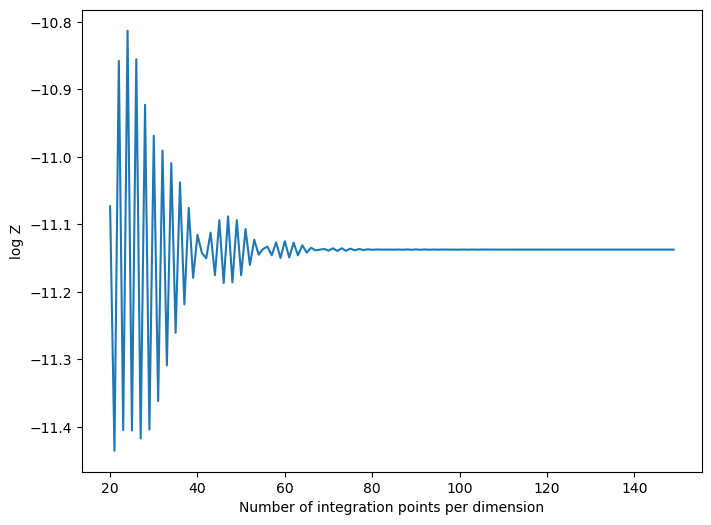

In [187]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(integration_samples**(1/3), jnp.log(integration_result_arr))
ax.set(xlabel='Number of integration points per dimension', ylabel='log Z')
plt.show()

In [188]:
with open('ground_truth_logZ.pkl', 'wb') as handle:
    pickle.dump({
        'N_per_dim': integration_samples**(1/3),
        'logZ': jnp.log(integration_result_arr)
                }, handle)

In [189]:

def mu_integral_1d(x, C_i, C_j, integration_index):
    if integration_index==0:
        return mu_integral(jnp.concatenate([x, C_i, C_j]))
    elif integration_index==1:
        return mu_integral(jnp.concatenate([C_i, x, C_j]))
    elif integration_index==2:
        return mu_integral(jnp.concatenate([C_i, C_j, x]))
    else:
        raise ValueError 

In [190]:
mu_integral_1d_vectorised = jax.jit(jax.vmap(mu_integral_1d, in_axes=(0, None, None, None)), static_argnums=(3))

In [196]:
integration_index = 2
C_contour_bins = jnp.linspace(-8, 8, 100)
C_i, C_j = jnp.meshgrid(C_contour_bins, C_contour_bins, indexing='ij')
integration_result_2d_arr = np.zeros_like(C_i)
for i in trange(len(C_contour_bins)):
    for j in range(len(C_contour_bins)):
        integral_result = trap.integrate(lambda x: mu_integral_1d_vectorised(x, jnp.array([C_i[i,j]]), jnp.array([C_j[i,j]]), integration_index), dim=1, N=int(int_N), integration_domain=[integration_domain[0]], backend='jax')
        integration_result_2d_arr[i,j] = integral_result


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


In [643]:
ground_truth_contours = {
    'X': C_i,
    'Y': C_j,
    'C0xC1': integration_result_2d_arr}

In [644]:
contour_68 = fsolve(lambda x: jnp.sum(integration_result_2d_arr[integration_result_2d_arr > x])/jnp.sum(integration_result_2d_arr) - 0.68, 1e-8)[0]
contour_95 = fsolve(lambda x: jnp.sum(integration_result_2d_arr[integration_result_2d_arr > x])/jnp.sum(integration_result_2d_arr) - 0.95, 1e-8)[0]

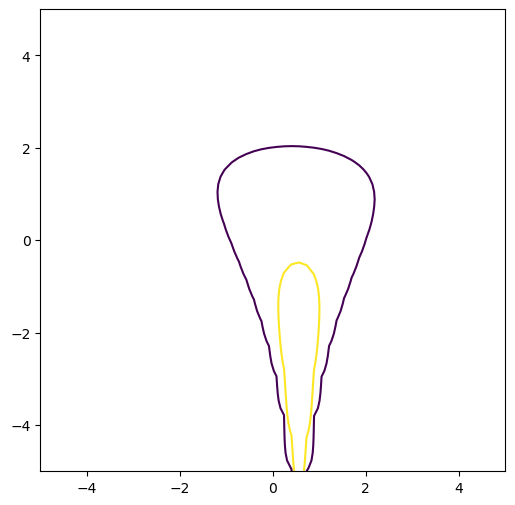

In [646]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.contour(C_i, C_j, integration_result_2d_arr, levels=[contour_95, contour_68])
# ax.contour(C_j, C_i, integration_result_2d_arr, levels=[contour_95, contour_68])
ax.set(xlim=[-5,5], ylim=[-5,5])
plt.show()

In [647]:
integration_index = 0
integration_result_2d_arr = np.zeros_like(C_i)
for i in trange(len(C_contour_bins)):
    for j in range(len(C_contour_bins)):
        integral_result = trap.integrate(lambda x: mu_integral_1d_vectorised(x, jnp.array([C_i[i,j]]), jnp.array([C_j[i,j]]), integration_index), dim=1, N=int(150), integration_domain=[integration_domain[0]], backend='jax')
        integration_result_2d_arr[i,j] = integral_result
ground_truth_contours['C1xC2'] = integration_result_2d_arr

100%|█████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s]


In [649]:
integration_index = 1
integration_result_2d_arr = np.zeros_like(C_i)
for i in trange(len(C_contour_bins)):
    for j in range(len(C_contour_bins)):
        integral_result = trap.integrate(lambda x: mu_integral_1d_vectorised(x, jnp.array([C_i[i,j]]), jnp.array([C_j[i,j]]), integration_index), dim=1, N=int(150), integration_domain=[integration_domain[0]], backend='jax')
        integration_result_2d_arr[i,j] = integral_result
ground_truth_contours['C0xC2'] = integration_result_2d_arr

100%|█████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]


In [650]:
def mu_integral_2d_equalij(x, mu_i, C_j, corner_index):
    indices = [i for i in range(3) if i != corner_index]
    return mu_integral(x, data=data[..., indices])/(2*jnp.pi*10)*jnp.exp(-0.5*mu_i**2/10-0.5*C_j**2/10)/(2*jnp.pi*jnp.exp(C_j))*jnp.exp(jnp.sum(-0.5*(data[..., corner_index]-mu_i)**2/jnp.exp(C_j)))

In [655]:
mu_integral_1d_vectorised = jax.jit(jax.vmap(mu_integral_2d_equalij, in_axes=(0, None, None, None)), static_argnums=(3))

In [656]:
corner_index = 0
integration_result_2d_arr = np.zeros_like(C_i)
for i in trange(len(C_contour_bins)):
    for j in range(len(C_contour_bins)):
        integral_result = trap.integrate(lambda x: mu_integral_1d_vectorised(x, jnp.array([C_i[i,j]]), jnp.array([C_j[i,j]]), corner_index), dim=2, N=int(150), integration_domain=[integration_domain[0], integration_domain[0]], backend='jax')
        integration_result_2d_arr[i,j] = integral_result
ground_truth_contours['mu0xC0'] = integration_result_2d_arr

100%|█████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]


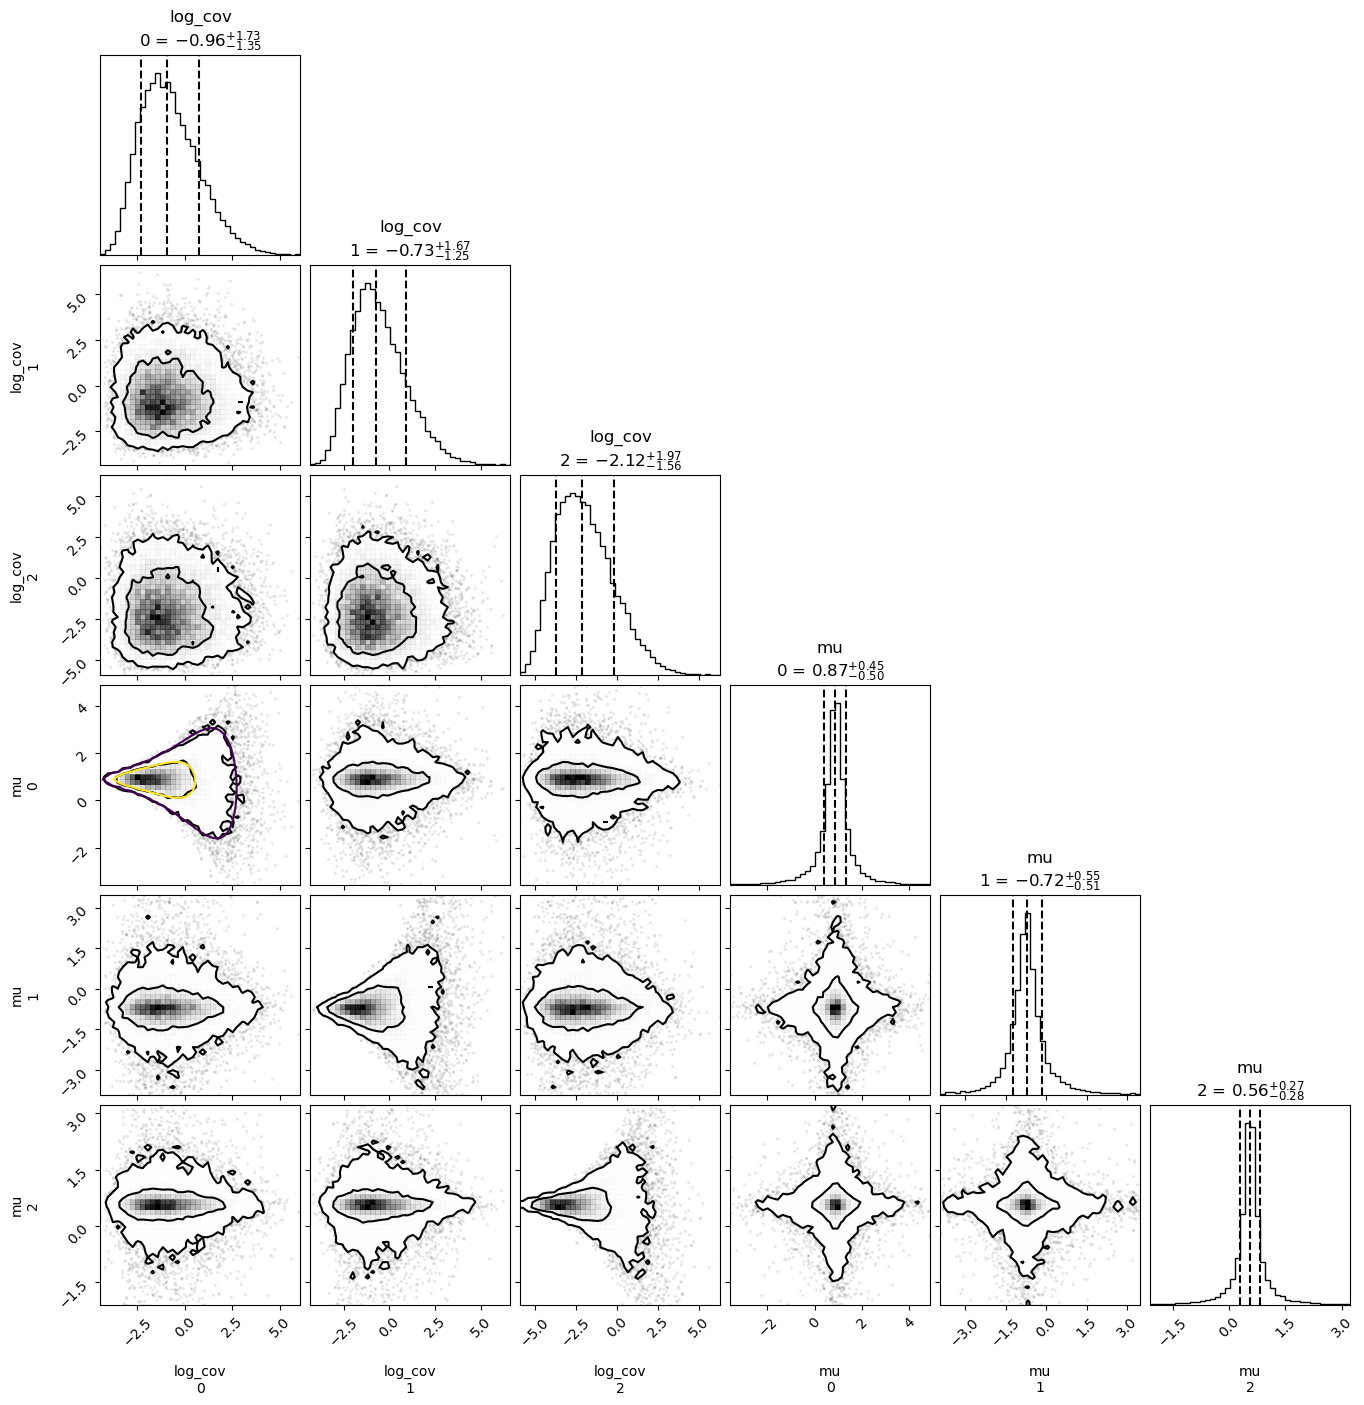

In [658]:
contour_68 = fsolve(lambda x: jnp.sum(integration_result_2d_arr[integration_result_2d_arr > x])/jnp.sum(integration_result_2d_arr) - 0.68, 1e-8)[0]
contour_95 = fsolve(lambda x: jnp.sum(integration_result_2d_arr[integration_result_2d_arr > x])/jnp.sum(integration_result_2d_arr) - 0.95, 1e-9)[0]
fig = corner.corner(arviz_obj, quantiles=[0.16, 0.5, 0.84], show_titles=True, divergences=True, levels=[0.95, 0.68], bins=40, var_names=['~auto_shared_latent'])

axes = np.array(fig.axes).reshape((6, 6))

axes[3,0].contour(C_j, C_i, integration_result_2d_arr, levels=[contour_95, contour_68])
plt.show()

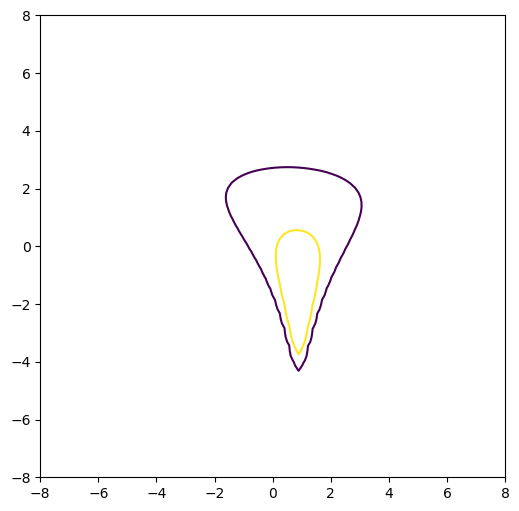

In [659]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.contour(C_i, C_j, integration_result_2d_arr, levels=[contour_95, contour_68])
# ax.contour(C_j, C_i, integration_result_2d_arr, levels=[contour_95, contour_68])
# ax.set(xlim=[-5,5], ylim=[-5,5])
plt.show()

In [660]:
corner_index = 1
integration_result_2d_arr = np.zeros_like(C_i)
for i in trange(len(C_contour_bins)):
    for j in range(len(C_contour_bins)):
        integral_result = trap.integrate(lambda x: mu_integral_1d_vectorised(x, jnp.array([C_i[i,j]]), jnp.array([C_j[i,j]]), corner_index), dim=2, N=int(150), integration_domain=[integration_domain[0], integration_domain[0]], backend='jax')
        integration_result_2d_arr[i,j] = integral_result
ground_truth_contours['mu1xC1'] = integration_result_2d_arr

100%|█████████████████████████████████████████| 100/100 [01:06<00:00,  1.49it/s]


In [661]:
corner_index = 2
integration_result_2d_arr = np.zeros_like(C_i)
for i in trange(len(C_contour_bins)):
    for j in range(len(C_contour_bins)):
        integral_result = trap.integrate(lambda x: mu_integral_1d_vectorised(x, jnp.array([C_i[i,j]]), jnp.array([C_j[i,j]]), corner_index), dim=2, N=int(150), integration_domain=[integration_domain[0], integration_domain[0]], backend='jax')
        integration_result_2d_arr[i,j] = integral_result
ground_truth_contours['mu2xC2'] = integration_result_2d_arr

100%|█████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


In [662]:
with open('ground_contours.pkl', 'wb') as handle:
    pickle.dump(ground_truth_contours, handle)

In [198]:

def mu_integral_2d_for_histogram(x, C_i):
    return mu_integral(jnp.concatenate([C_i, x]))

mu_integral_2d_for_histogram_vectorised = jax.jit(jax.vmap(mu_integral_2d_for_histogram, in_axes=(0, None)))

In [215]:
bins_for_1d_hist = np.linspace(-8, 8, 500)

C_i_pdf = []

for i in trange(len(bins_for_1d_hist)):
    C_i_pdf.append(trap.integrate(lambda x: mu_integral_2d_for_histogram_vectorised(x, jnp.array([bins_for_1d_hist[i]])), dim=2, N=int(150**2), integration_domain=integration_domain[0:2], backend='jax'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.87it/s]


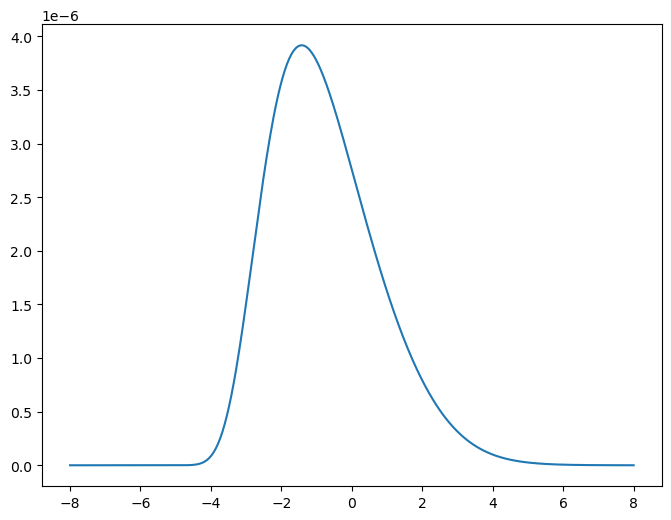

In [217]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(bins_for_1d_hist, C_i_pdf)
plt.show()

In [218]:
def mu_integral_2d_for_histogram_2(x, mu_i):
    indices = [1,2]
    return mu_integral(x, data=data[..., indices])/(2*jnp.pi*10)*jnp.exp(-0.5*mu_i**2/10-0.5*x[0]**2/10)/(2*jnp.pi*jnp.exp(x[0]))*jnp.exp(jnp.sum(-0.5*(data[..., 0]-mu_i)**2/jnp.exp(x[0])))

mu_integral_2d_for_histogram_2_vectorised = jax.jit(jax.vmap(mu_integral_2d_for_histogram_2, in_axes=(0, None,)))

In [219]:

mu_i_pdf = []

for i in trange(len(bins_for_1d_hist)):
    mu_i_pdf.append(trap.integrate(lambda x: mu_integral_2d_for_histogram_2_vectorised(x, jnp.array([bins_for_1d_hist[i]])), dim=2, N=int(150**2), integration_domain=integration_domain[0:2], backend='jax'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 92.86it/s]


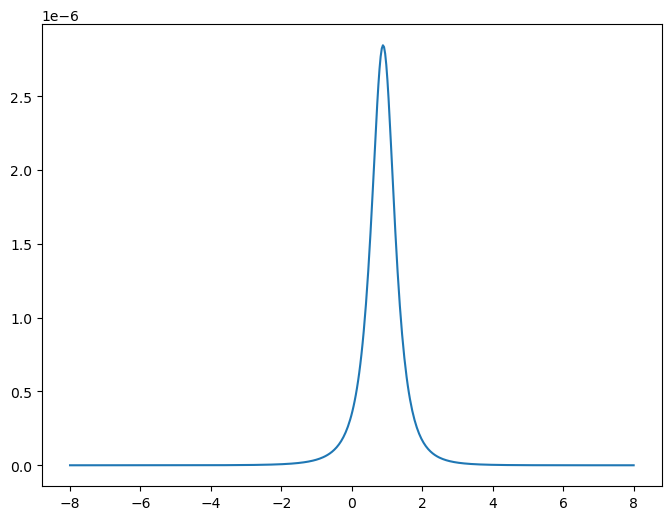

In [221]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(bins_for_1d_hist, mu_i_pdf)
plt.show()

In [222]:
with open('ground_pdfs.pkl', 'wb') as handle:
    pickle.dump({
        'x': bins_for_1d_hist,
        'mu': mu_i_pdf,
        'C': C_i_pdf
    }, handle)